# Reservoir Computing with Genetic Oscillators
This notebook contains a full explanation of how to use our OscillatorReservoir class for classification and forecasting, as well as hyper-parameter optimization.

We will also perform important visualisations along to way to help understand the tasks.

## Global Configuration
Firstly, we must setup our environment.


In [1]:
import numpy as np
import reservoirpy as rpy
import matplotlib.pyplot as plt

from utils.logger import Logger

# Set global random state for reproducibility
SEED = 1337

# Set our logging level to 1 (DEBUG)
LOG_LEVEL = 1

# Set reservoirpy verbosity to 1 (enabled)
VERBOSITY = 0

# We define here if we want to use our reservoir.reservoir.OscillatorReservoir, or the reservoirpy.nodes.Reservoir
USE_OSCILLATORS = False

# Fix our random state generators
rpy.set_seed(SEED)
rpy.verbosity(VERBOSITY)
np.random.seed(SEED)

# Initialize our logger with a log file
log_name = "reservoir-computing-tutorial"
log_file = f"logs/{log_name}.log"
logger = Logger(level=LOG_LEVEL, log_file=log_file)



## Loading our dataset for classification

In [2]:
from utils.preprocessing import load_ecg_data

instances = 4015
encode_labels = True
binary = False
test_ratio = 0.2

X_train, Y_train, X_test, Y_test = load_ecg_data(
    rows=instances,
    test_ratio=test_ratio,
    encode_labels=encode_labels,
    binary=binary)

2024-04-20 20:48:13 - [INFO] - Loading ECG Dataset
2024-04-20 20:48:13 - [DEBUG] - Loading preprocessed dataset from: data/ecg/ecg_data.npz
2024-04-20 20:48:13 - [DEBUG] - Normalizing inputs
2024-04-20 20:48:13 - [DEBUG] - Balancing classes
2024-04-20 20:48:13 - [DEBUG] - Limiting instances to 4015 rows
2024-04-20 20:48:13 - [DEBUG] - Splitting dataset into training and testing sets
2024-04-20 20:48:13 - [DEBUG] - Train:Test dataset ratio: [80:20]
2024-04-20 20:48:13 - [DEBUG] - One-hot encoding labels.
2024-04-20 20:48:13 - [DEBUG] - Reshaping data into time-series.
2024-04-20 20:48:13 - [DEBUG] - ----- Dataset Parameters -----
2024-04-20 20:48:13 - [DEBUG] - instances: 4015
2024-04-20 20:48:13 - [DEBUG] - encode_labels: True
2024-04-20 20:48:13 - [DEBUG] - repeat_targets: False
2024-04-20 20:48:13 - [DEBUG] - normalize: True
2024-04-20 20:48:13 - [DEBUG] - test_ratio: 0.2
2024-04-20 20:48:13 - [DEBUG] - shuffle: True
2024-04-20 20:48:13 - [DEBUG] - binary: False
2024-04-20 20:48:13 -

## Visualising our ECG data

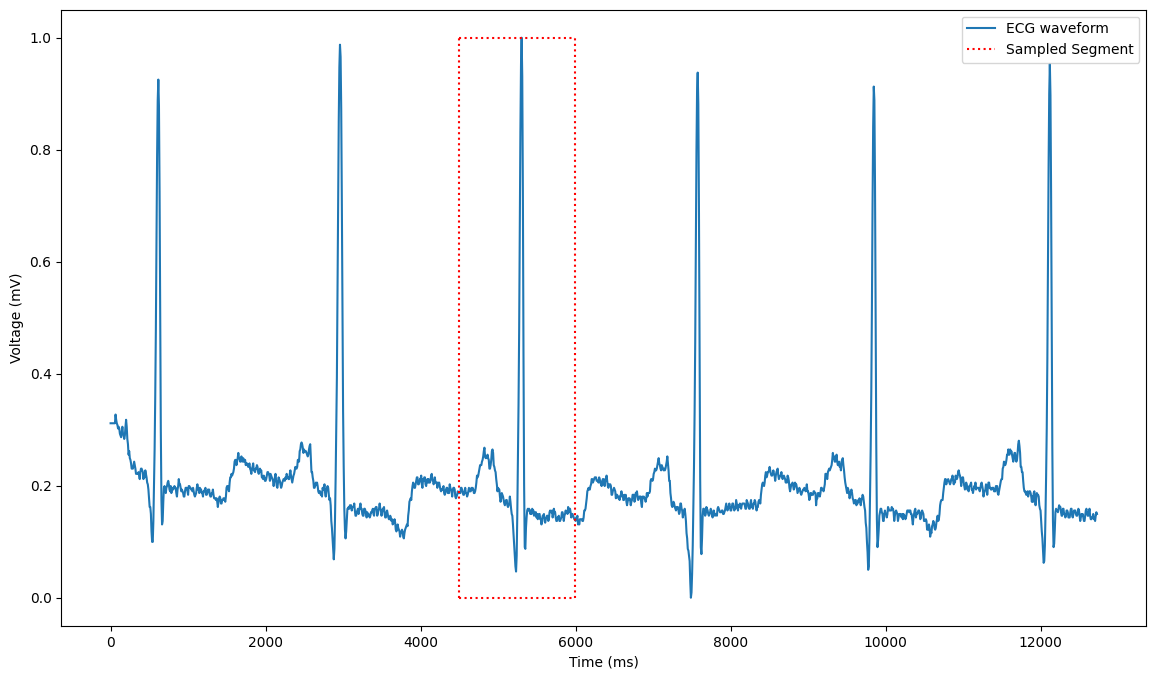

In [3]:
from utils.preprocessing import load_ecg_forecast

timesteps = 2000
X_forecast, _, _, _ = load_ecg_forecast(timesteps=timesteps)
sampling_freq = 125
num_samples = len(X_forecast)
time_ms = np.arange(num_samples) / sampling_freq * 1000

# Plot the ECG waveform
plt.figure(figsize=(14, 8))
plt.plot(time_ms, X_forecast, label='ECG waveform')

# Calculate box width in ms
box_width = 187 * 1000 / sampling_freq
start_x = 4500

# Plot the box
plt.plot([start_x, start_x + box_width], [min(X_forecast), min(X_forecast)], linestyle=':', color='red', label="Sampled Segment")
plt.plot([start_x, start_x + box_width], [max(X_forecast), max(X_forecast)], linestyle=':', color='red')
plt.plot([start_x, start_x], [min(X_forecast), max(X_forecast)], linestyle=':', color='red')
plt.plot([start_x + box_width, start_x + box_width], [min(X_forecast), max(X_forecast)], linestyle=':', color='red')

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

## Visualising our system of delay differential equations
Our genetic oscillator nodes perform their activation of a time series input using a system of delay differential equations, encapsulating the behaviour exhibited during gene expression within a cell.

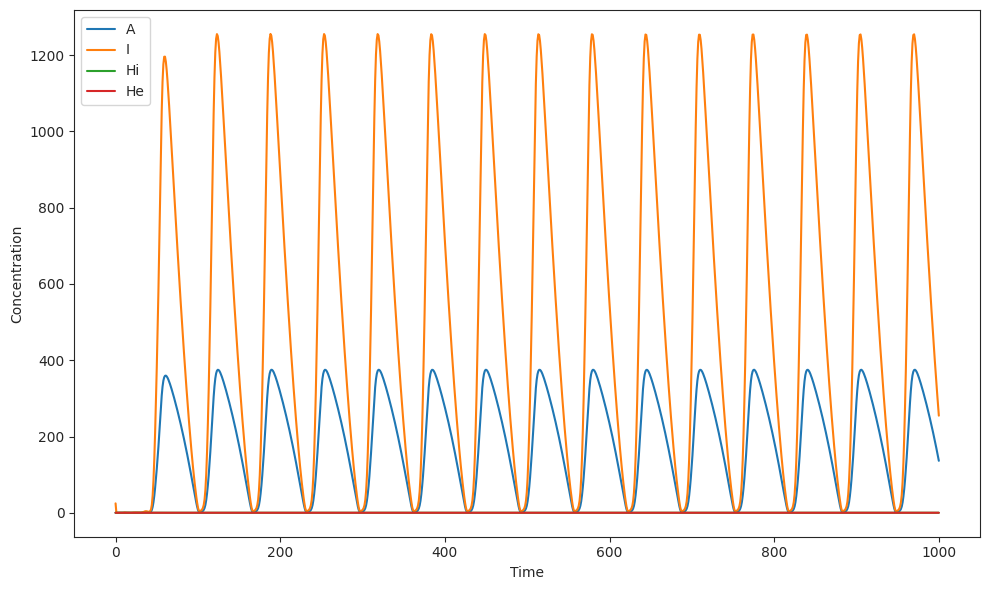

In [4]:
from reservoir.node import Oscillator
from utils.visualisation import plot_states

timesteps = 1000
coupling = 1e-5

timespan = np.linspace(0, timesteps, timesteps)
sine_wave = np.sin(timespan)
oscillator = Oscillator(timesteps=timesteps, delay=10, initial_values=[0, 100, 0, 0])

states = []
for i in range(timesteps):
    states.append(oscillator.forward(sine_wave[i] * coupling))

plot_states(np.array(states), labels=["A", "I", "Hi", "He"], ylabel="Concentration", title="", legend=True, show=True)

## Initializing our Reservoir and Readout Nodes

In [5]:
from reservoir.reservoir import OscillatorReservoir
from reservoirpy.nodes import Reservoir, Ridge

timesteps = X_train[0].shape[0]
nodes = 500
delay = 10
initial_conditions = [0, 100, 0, 0]

if USE_OSCILLATORS:
    reservoir = OscillatorReservoir(
        units=nodes,
        timesteps=timesteps,
        delay=delay,
        initial_values=initial_conditions,
        seed=SEED)
else:
    reservoir = Reservoir(units=nodes)

ridge = 1e-5
readout = Ridge(ridge=1e-5)

## Visualising Reservoir States
This method plots the reservoir states for a single instance of data

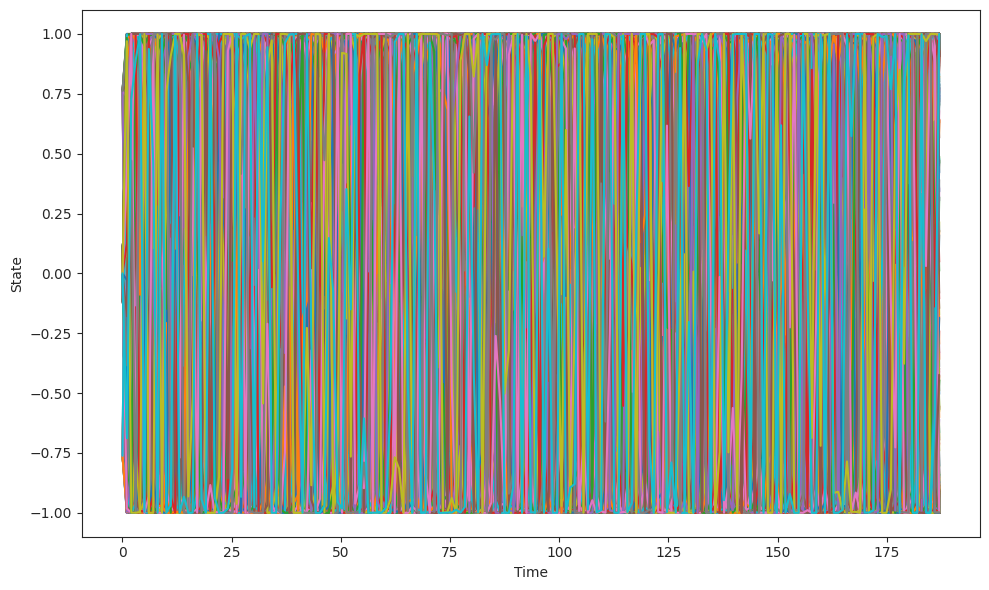

In [6]:
iterations = 1

labels = [f"Node: {i}" for i in range(reservoir.units)]
for x in X_train[:iterations]:
    plot_states(reservoir.run(x), labels, legend=False)

## Analysing our Classification ECG Dataset
Next, we analyse our dataset which we will use for classification

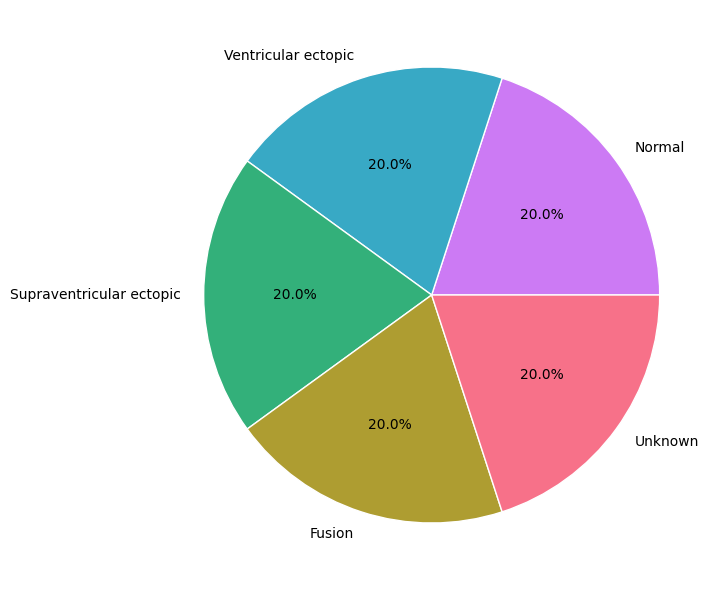

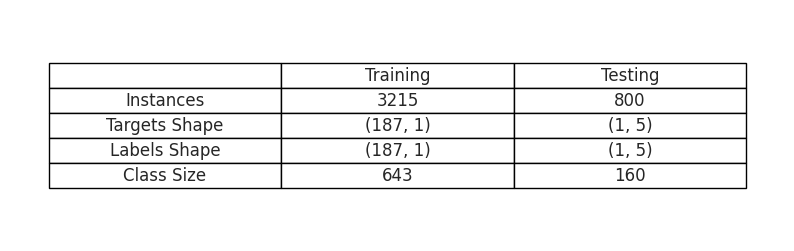

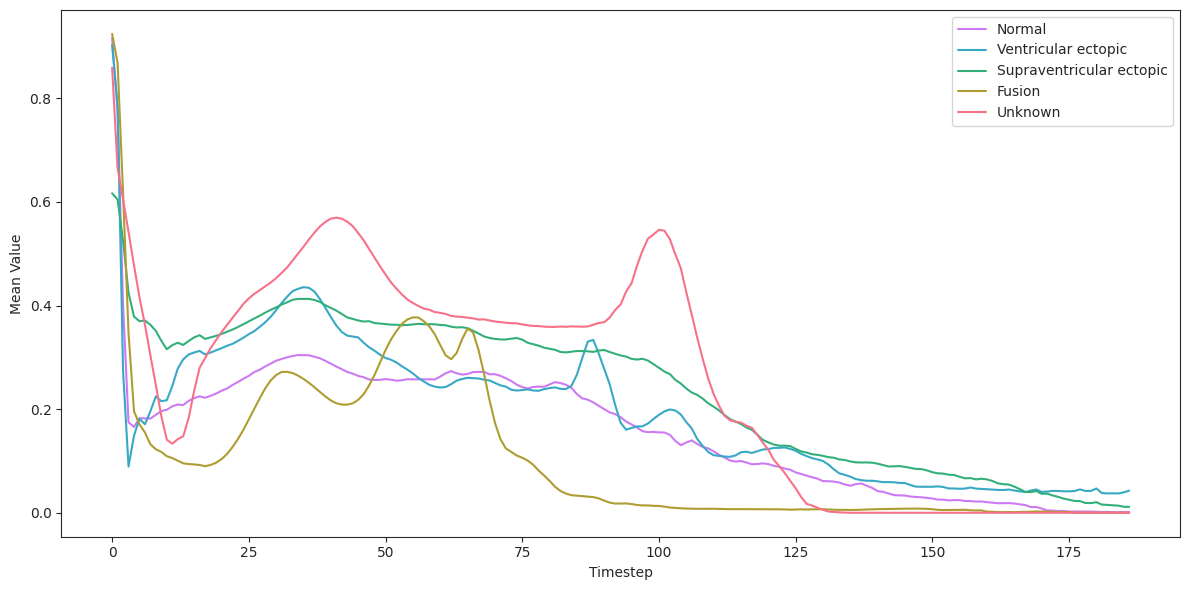

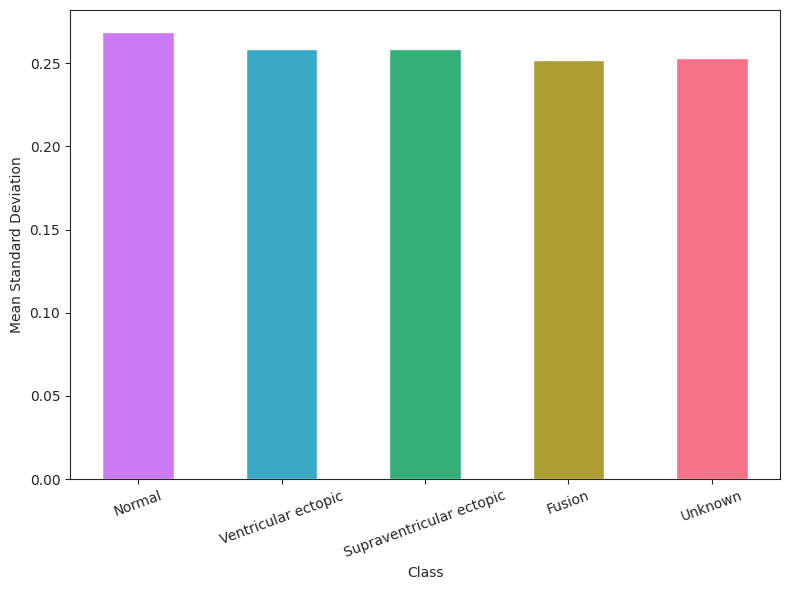

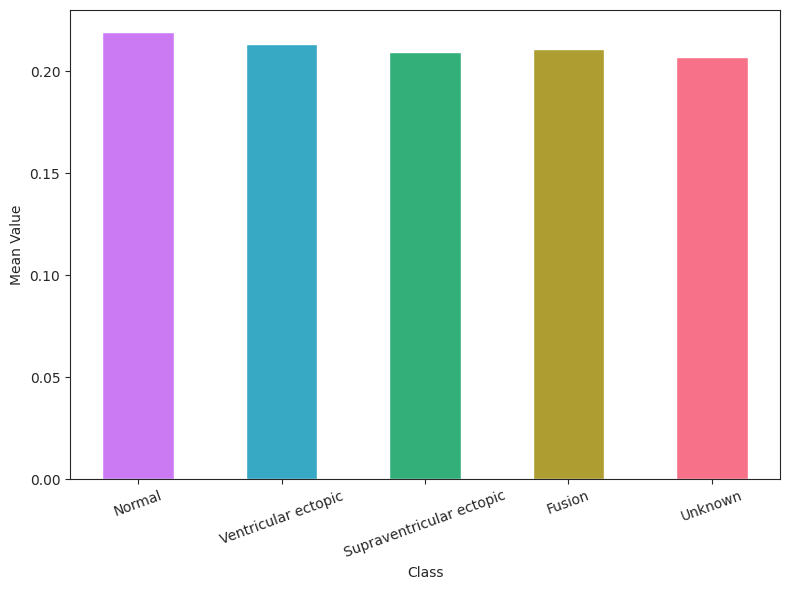

In [7]:
from utils.visualisation import plot_data_distribution
from utils.visualisation import plot_dataset_info
from utils.visualisation import plot_average_instance
from utils.visualisation import plot_class_std
from utils.visualisation import plot_class_mean

# concatenate the training and test subsets into one
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

# plot the dataset information, show and save to file
plot_data_distribution(Y, filename="data-distribution.png", show=True)
plot_dataset_info(X_train, Y_train, X_test, Y_test, filename="dataset-info.png", show=True)
plot_average_instance(X, Y, filename="average-instance", show=True)
plot_class_std(X, Y, filename="std.png", show=True)
plot_class_mean(X, Y, filename="means.png", show=True)

## Classification
Finally, with our dataset and model now setup, we can perform classification.

Note: This is very computationally intensive and will have a run-time of around ~1 hour for 50 nodes and 1000 instances.

In [8]:
from utils.classification import classify

folds = 5

# create our descriptive filename to save the results to
binary_tag = "-binary" if binary else ""
filename = f"results/runs/{reservoir.name}-{nodes}-{len(X_train)}{binary_tag}"

# perform classification
metrics = classify(reservoir, readout, X_train, Y_train, X_test, Y_test, folds=folds, save_file=filename)


2024-04-20 20:49:03 - [DEBUG] - ----- Reservoir Hyper-parameters -----
2024-04-20 20:49:03 - [DEBUG] - lr: 1.0
2024-04-20 20:49:03 - [DEBUG] - sr: None
2024-04-20 20:49:03 - [DEBUG] - input_scaling: 1.0
2024-04-20 20:49:03 - [DEBUG] - bias_scaling: 1.0
2024-04-20 20:49:03 - [DEBUG] - fb_scaling: 1.0
2024-04-20 20:49:03 - [DEBUG] - rc_connectivity: 0.1
2024-04-20 20:49:03 - [DEBUG] - input_connectivity: 0.1
2024-04-20 20:49:03 - [DEBUG] - fb_connectivity: 0.1
2024-04-20 20:49:03 - [DEBUG] - noise_in: 0.0
2024-04-20 20:49:03 - [DEBUG] - noise_rc: 0.0
2024-04-20 20:49:03 - [DEBUG] - noise_out: 0.0
2024-04-20 20:49:03 - [DEBUG] - noise_type: normal
2024-04-20 20:49:03 - [DEBUG] - activation: <function tanh at 0x7fdb9050a170>
2024-04-20 20:49:03 - [DEBUG] - fb_activation: <function identity at 0x7fdb9050a290>
2024-04-20 20:49:03 - [DEBUG] - units: 500
2024-04-20 20:49:03 - [DEBUG] - noise_generator: functools.partial(<function noise at 0x7fdb5213a320>, rng=Generator(PCG64) at 0x7FDB512F6EA0

## Plotting metrics per fold

In [ ]:
from utils.visualisation import plot_metrics_across_folds
from utils.preprocessing import load_npz

folds_metrics = []
folds_data = []

# loop across each fold and concatenate the data and metrics
for fold in range(folds):
    fold_filename = filename + f"-fold-{str(fold)}.npz"
    fold_data = load_npz(fold_filename, allow_pickle=True)
    if fold_data is not None:
        metrics = fold_data['metrics'].item()
        folds_data.append(fold_data)
        folds_metrics.append(metrics)
    else:
        logger.error(f"Fold data does not exist at: {fold_filename}")

# plot the metrics across the folds
plot_metrics_across_folds(folds_metrics)

## Plot aggregated metrics

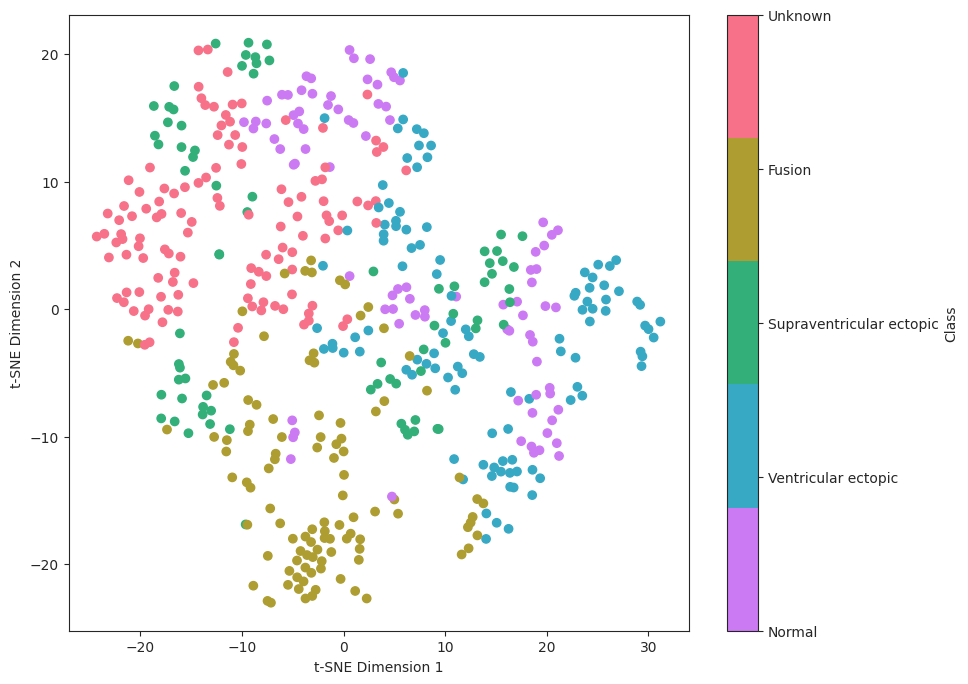

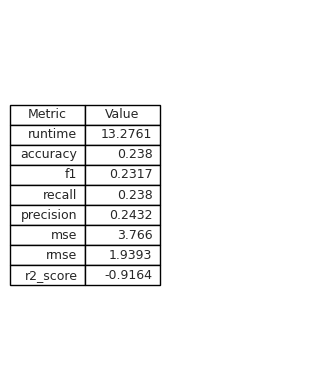

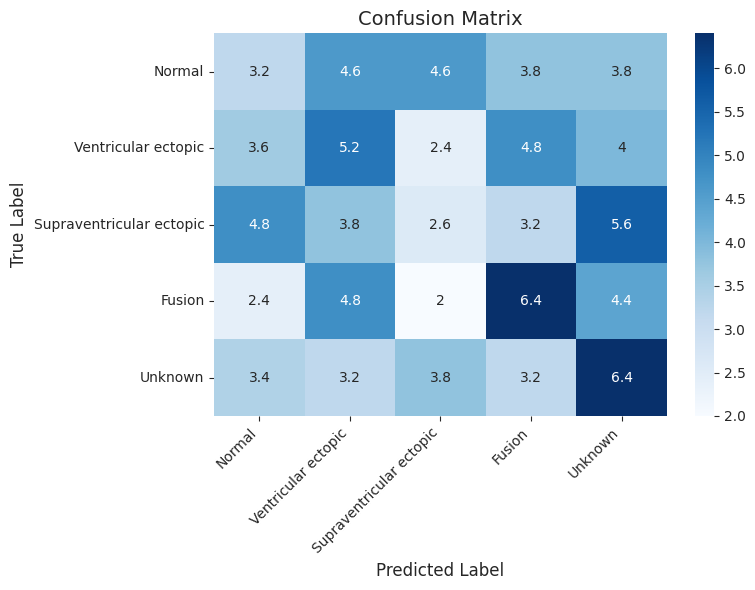

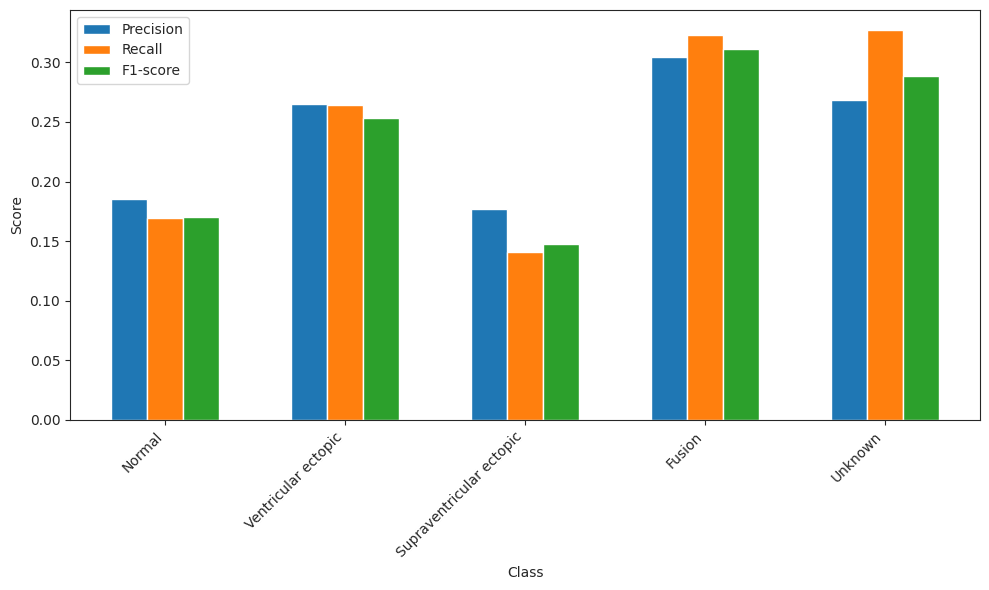

In [ ]:
from utils.visualisation import plot_tsne_clustering
from utils.visualisation import plot_confusion_matrix
from utils.visualisation import plot_class_metrics
from utils.visualisation import plot_metrics_table
import numpy as np
from utils.classification import compute_mean_metrics

# concatenate the predictions across the folds
Y_pred = []
for fold in range(folds):
    Y_pred.append(folds_data[fold]['Y_pred'])

Y_pred = np.concatenate(Y_pred)

metrics = compute_mean_metrics(folds_metrics)

plot_tsne_clustering(Y_pred, show=True)
plot_metrics_table(metrics)
plot_confusion_matrix(metrics['confusion_matrix'])
plot_class_metrics(metrics['class_metrics'])

## Forecasting
Forecasting is performed significantly differently, and therefore we must redefine our model hyperparameters here, and load our forecasting dataset.

In [ ]:
from utils.visualisation import plot_forecast_results, plot_forecast_data

# Forecating requires significantly different hyperparameters to classification, therefore we must redefine our data and model

timesteps = 2510
forecast_steps = 1
test_ratio = 0.2

# load forecasting dataset, where the test set is "forecast" timesteps ahead of the training test set
X_train, Y_train, X_test, Y_test = load_ecg_forecast(
    timesteps=timesteps, 
    forecast=forecast_steps, 
    test_ratio=test_ratio)


timesteps = X_train[0].shape[0]
nodes = 50
delay = 1
initial_conditions = [500, 500, 0, 0]
rc_scaling = 1e-5
coupling = 1e-3
input_connectivity = 1.0
rc_connectivity = 1.0

if USE_OSCILLATORS:
    reservoir = OscillatorReservoir(
        units=nodes,
        timesteps=timesteps,
        delay=delay,
        initial_values=initial_conditions,
        coupling=coupling,
        rc_scaling=rc_scaling,
        input_connectivity=input_connectivity,
        rc_connectivity=rc_connectivity,
        seed=SEED)
else:
    reservoir = Reservoir(units=nodes)

ridge = 1e-7
readout = Ridge(ridge=ridge)

plot_forecast_data(X_train, Y_train, X_test, Y_test)

esn = reservoir >> readout
# Fit ESN and train
esn.fit(X_train, Y_train)
Y_pred = esn.run(X_test)

mse = np.mean((Y_test - Y_pred) ** 2)
rmse = np.sqrt(mse)

plot_forecast_results(Y_pred, Y_test)